# Create Baseline model<br/>*Iteration 1*

## Goals
* Create simple baseline model
* Measure performance using cross validation
* Compare baseline model with null model

Some people use "baseline model" synonymously with "null model".

Here, I refer to the null model as the simplest possible model, such as predicting the predominant target class value for classification or the average target value for regression.

Here, I refer to the baseline model as any very simple model used as the first model in the iterative model development process.

Note that all notebooks use Scikit Learn v0.21.  If you are using an earlier version of Scikit Learn, you may have to convert X to float.  Later versions of Scikit Learn allow X to be of any numeric type (float, int, boolean).

### Iterative Model Development
This series of notebooks is about iterative model development with Scikit Learn.

Several notebooks will be created after this one.  Each iteratively improving:
* the model's accuracy
* the workflow used to create the model

The workflow will be encapsulated primarily in two functions:
1. get\_Xy\_<version\>
   * encodes the raw data into X and y
2. get\_ct\_<version\>
   * gets ColumnTransformer to be applied to X
   
These functions are in a separate file, titanic_helper_code.py which is imported.  Upon first use, these functions are copied into the notebook to show the code.

In [1]:
# show titanic_helper_code.py is in current directory
!ls titanic_helper_code.py

titanic_helper_code.py


<a name="outline"></a>

## Outline
1. [Acquire and Read Data](#readdata)
2. [Identify Target and Feature Variables](#target)
3. [First Iteration Assumptions](#assumptions)
4. [Model Building](#model)
5. [Model Evaluation: Cross Validation](#crossvalidation)
6. [Cross Validation Details](#kfold)
7. [Compare with Null Model](#modelcompare)
8. [Model Summary](#modelsummary)
9. [Notebook Summary](#summary)

### Common Imports and Notebook Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [3]:
# Version Information
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)
!lsb_release -d

python:      3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
numpy:       1.17.4
pandas:      0.25.3
matplotlib:  3.1.3
seaborn:     0.9.0
sklearn:     0.22
Description:	Ubuntu 18.04.4 LTS


<a name="readdata"></a>

### 1. Acquire and Read Data
[Back to Outline](#outline)

Download "train.csv" from: https://www.kaggle.com/c/titanic/data and place it in a data subdirectory.

For this example of supervised learning, we will only consider labeled data. The labeled dataset is named "train.csv".

In [4]:
# read data
all_data = pd.read_csv('./data/train.csv')
all_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<a name="target"></a>

### 2. Identify Target and Feature Variables
[Back to Outline](#outline)

Create two variables in preparation for creating a predictive model.  

X: A Pandas DataFrame that represents the features (aka attributes)  
y: A Pandas Series that represents the target (aka response)  

The target variable is Survived.

In [5]:
# X: drop target variable
# y: keep only the target
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']
print('X Shape: ', X.shape)
print('y Shape: ', y.shape)
print('X Type: ', type(X))
print('y Type: ', type(y))

X Shape:  (891, 11)
y Shape:  (891,)
X Type:  <class 'pandas.core.frame.DataFrame'>
y Type:  <class 'pandas.core.series.Series'>


<a name="assumptions"></a>

### 3. First Iteration Assumptions
[Back to Outline](#outline)  

The first step is to get a reasonable model up and running quickly.  After a model is up an running, iterative improvements can be made.

As per the EDA from the previous notebook, Sex, and Pclass are among the most promising predictors.  Age and Title are also promising, but these will be handled in later notebooks as they require imputation and dummy variable encoding, respectively.

In [6]:
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
drop_columns = ['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Fare',
                'Ticket', 'Cabin', 'Embarked']
X = X.drop(drop_columns, axis=1)
X.head(3)

,Pclass,Sex
0,3,male
1,1,female
2,3,female


In [8]:
# Encode Sex as a number
X['Sex'] = X['Sex'].replace({'female':1, 'male':0})
X.head(3)

,Pclass,Sex
0,3,0
1,1,1
2,3,1


The data is can now be used by a Scikit Learn estimator.

Note: Regularization will be used and yet the predictors, in this iteration, will not be standardized. In subsequent notebooks, the predictors will be standardized.

#### Learning Algorithms
Most learning algorithms use Linear Algebra.  Linear Algebra only works with non-null numeric values.  Even though the Scikit Learn API is well above the level of the Linear Algebra used by the learning algorithms, it is still necessary to present the learning algorithms with a 2D matrix of non-null numbers.

#### Consequences of Requiring 2D Numeric Array without Nulls

Real-world data consists of many different types of data, such as:
* numeric (discrete and continuous)
* categorical (ordered and unordered)
* text
* time series
* images
* and more ...

To use Scikit Learn, each of the above must be converted to a 2D array of numbers.  In addition, missing values (e.g. np.nan) must also be converted to a number.

Scikit Learn is perhaps best used for numeric, categorical, and text data.  Scikit Learn has data transformers which can be used to:
* convert categorical values to numbers
* convert missing values to numbers
* convert text to numerical attributes

Although Scikit Learn has good support for text data, specialized libraries such as [NLTK](https://www.nltk.org/) may be better for advanced applications.

Traditional time series analysis can be done with [StatsModels](https://www.statsmodels.org/stable/index.html) and similar libraries.  Scikit Learn can be used by restructuring the input data.  The combination of StatsModels and Scikit Learn can be used to create excellent time series models.

Image classification is best done with deep learning, which is better supported by [Keras](https://github.com/keras-team/keras) and [TensorFlow](https://github.com/tensorflow/tensorflow) than by Scikit Learn.

In [9]:
# Copied from titanic_helper_code.py to show the code
def get_Xy_v1(filename='./data/train.csv'):
    """Data Encoding

    Version 1
    * Pclass and Sex encoded as 1/0
    """

    # read data
    all_data = pd.read_csv(filename)
    X = all_data.drop('Survived', axis=1)
    y = all_data['Survived']
    
    # encode data
    X['Sex'] = X['Sex'].replace({'female':1, 'male':0})
    
    # drop unused columns
    drop_columns = ['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 
                    'Fare', 'Ticket', 'Cabin', 'Embarked']
    X = X.drop(drop_columns, axis=1)
    
    return X, y

In [10]:
X, y = tt.get_Xy_v1()
X.dtypes

Pclass    int64
Sex       int64
dtype: object

<a name="model"></a>

### 4.  Model Building
[Back to Outline](#outline)

In [11]:
# Create instance of LogisticRegression estimator
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')

<a name="crossvalidation"></a>

### 5. Model Evaluation: Cross Validation
[Back to Outline](#outline)

Scikit Learn has a good description of [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html)

Good resources for understanding cross validation and overfitting in general:
* chapter 5.1 of [ISL](http://www-bcf.usc.edu/~gareth/ISL/)
* The first 3 videos for Chapter 5 [ISL Videos](http://www.dataschool.io/15-hours-of-expert-machine-learning-videos/)
<a name="kfold"></a>

### 6. Cross Validation Details
[Back to Outline](#outline)  

For classification problems, StratifiedKFold() is preferable to KFold().  With StratifiedKFold(), the target class distribution will be maintained in each fold.

In general, shuffle=True, should be specified.  This effectively randomizes the order of the rows before using them.

Randomly selected data is more likely to be representative of the data as a whole, and is therefore preferred.

#### Cross Validation: Choosing K
As mentioned in the first notebook, generally K for *model selection* is lower than K for *model evaluation*.

For this series of notebooks:
* model selection: use 10x 2-Fold CV
* model evaluation: use 10x 10-Fold CV

#### Compute Cross Validated Scores with cross_val_score

In [12]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

# define a specific set of CV folds for repeatability
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, 
                                    random_state=108)

# instantiate an estimator
lr_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')

scores = cross_val_score(lr_model, X, y, cv=cv_select, scoring='accuracy')

print(f'{len(scores)} Scores  min:{scores.min():.3f} max:{scores.max():.3f}')
print(f'CV Mean Score: {scores.mean():.3f} +/- {scores.std():.3f}')

20 Scores  min:0.758 max:0.816
CV Mean Score: 0.787 +/- 0.016


In [13]:
# the above print statments are also in an imported helper function
tt.print_scores(scores)

20 Scores  min:0.758 max:0.816
CV Mean Score: 0.787 +/- 0.016


#### Compute Cross Validated Scores without cross_val_score
As cross_val_score() does a lot, it is instructive to code the above by hand.

In [14]:
from sklearn.metrics import accuracy_score

score_per_fold = []
for train_idx, test_idx in cv_select.split(X,y):
    
    # train subset
    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    
    # test subset
    X_test = X.iloc[test_idx, :]
    y_test = y[test_idx]
    
    # fit model on train
    lr_model.fit(X_train, y_train)
    
    # predict using fitted model on test
    predictions = lr_model.predict(X_test)
    
    # evaluate accuracy
    fold_score = accuracy_score(y_test, predictions)
    score_per_fold.append(fold_score)
    
my_scores = np.array(score_per_fold)    

print(f'{len(scores)} Scores  min:{scores.min():.3f} max:{scores.max():.3f}')
print(f'CV Mean Score: {scores.mean():.3f} +/- {scores.std():.3f}')

# compare with scores computed by cross_val_score() above
print('Scores match: ',(scores == my_scores).all())

20 Scores  min:0.758 max:0.816
CV Mean Score: 0.787 +/- 0.016
Scores match:  True


The scores match.  The computations are the same.  
The above for-loop does exactly the same thing as the following single line:
```python
scores = cross_val_score(lr_model, X, y, 
                         cv=cv_select, scoring='accuracy')
```
<a name="modelcompare"></a>

### 7. Compare with Null Model
[Back to Outline](#outline)

For a classifier, predicting the predominant class is the simplest possible model.  This is sometimes referred to as the "null model".

In [15]:
from sklearn.dummy import DummyClassifier

null_model = DummyClassifier(strategy='most_frequent',random_state=0)

null_model_scores = cross_val_score(null_model, X, y, cv=cv_select, 
                         scoring='accuracy')

print(f'{len(scores)} Scores min:{null_model_scores.min():.3f} max:{null_model_scores.max():.3f}')
print(f'Cross Validated Score: {null_model_scores.mean():.3f} +/- {null_model_scores.std():.3f}')

20 Scores min:0.616 max:0.617
Cross Validated Score: 0.616 +/- 0.000


Verify that this is the frequency of the predominant class (NotSurvived).

In [16]:
y.value_counts() / len(y)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

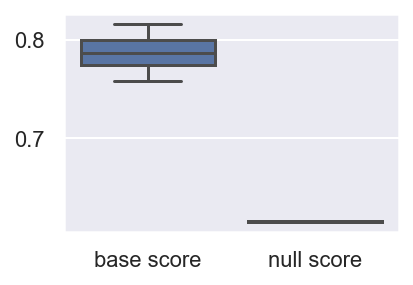

In [17]:
# compare the base_model with the null model graphically
plt.figure(figsize=(3,2), dpi=144)
df = pd.DataFrame(data=list(zip(scores, null_model_scores)),
                  columns=['base score','null score'])
sns.boxplot(data=df);
plt.savefig(fname='1_vs_0.png', dpi=120)

We see that the base model cross validated scores are well above the null model's score.
<a name="modelsummary"></a>

### 8. Model Summary
[Back to Outline](#outline)

Model building steps only.

In [18]:
X, y = tt.get_Xy_v1()

# define a specific set of CV folds for repeatability
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=108)

# instantiate an estimator
lr_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')

scores = cross_val_score(lr_model, X, y, cv=cv_select, scoring='accuracy')

# save scores for comparison with next iteration
np.save("./data/iter01.data", scores)

print(f'{len(scores)} Scores  min:{scores.min():.3f} max:{scores.max():.3f}')
print(f'CV Mean Score: {scores.mean():.3f} +/- {scores.std():.3f}')

20 Scores  min:0.758 max:0.816
CV Mean Score: 0.787 +/- 0.016


<a name="summary"></a>

### 9. Notebook Summary
[Back to Outline](#outline)

In this first iteration we:
* created a simple LogisticRegression model
* created a null model (aka DummyClassifier) for comparison 
* used cross validation to measure the accuracy of each model 
* showed that our baseline model accuracy (78.7%) is better than the null model (61.6%)